# Berlin weather with RAINVIEWER

In [263]:
import requests
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

import glob
import os

## 1. Getting the coordinates

In [ ]:
# https://www.geeksforgeeks.org/get-time-zone-of-a-given-location-using-python/

In [332]:
# input the name of the city

location_name = "Berlin"

In [373]:
# geolocator = Nominatim(user_agent="geoapiExercises")

In [374]:
# location = geolocator.geocode(location_name)
# my_coordinates = [location.latitude, location.longitude]
my_coordinates = [52.5170365, 13.3888599]

print("Location address:", location_name)
print("Latitude and Longitude of the said address:", (my_coordinates[0], my_coordinates[1]))

Location address: Berlin
Latitude and Longitude of the said address: (52.5170365, 13.3888599)


In [345]:
obj = TimezoneFinder()
tz_value = obj.timezone_at(lat=my_coordinates[0], lng=my_coordinates[1])
tz_value = pytz.timezone(tz_value)

print(tz_value)

Europe/Berlin


## 2. Conneting to API

In [ ]:
# https://www.rainviewer.com/api/weather-maps-api.html

In [271]:
weather_url = "https://api.rainviewer.com/public/weather-maps.json"
weather_response = requests.get(weather_url)
weather_response.status_code

200

In [272]:
# weather_response.text
weather_request = weather_response.request
weather_request.headers

{'User-Agent': 'python-requests/2.28.1', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}

In [273]:
weather_response.json()

{'version': '2.0',
 'generated': 1683617429,
 'host': 'https://tilecache.rainviewer.com',
 'radar': {'past': [{'time': 1683610200, 'path': '/v2/radar/1683610200'},
   {'time': 1683610800, 'path': '/v2/radar/1683610800'},
   {'time': 1683611400, 'path': '/v2/radar/1683611400'},
   {'time': 1683612000, 'path': '/v2/radar/1683612000'},
   {'time': 1683612600, 'path': '/v2/radar/1683612600'},
   {'time': 1683613200, 'path': '/v2/radar/1683613200'},
   {'time': 1683613800, 'path': '/v2/radar/1683613800'},
   {'time': 1683614400, 'path': '/v2/radar/1683614400'},
   {'time': 1683615000, 'path': '/v2/radar/1683615000'},
   {'time': 1683615600, 'path': '/v2/radar/1683615600'},
   {'time': 1683616200, 'path': '/v2/radar/1683616200'},
   {'time': 1683616800, 'path': '/v2/radar/1683616800'},
   {'time': 1683617400, 'path': '/v2/radar/1683617400'}],
  'nowcast': [{'time': 1683618000, 'path': '/v2/radar/nowcast_834b2f0fb970'},
   {'time': 1683618600, 'path': '/v2/radar/nowcast_834b0abe03d2'},
   {'t

In [274]:
print("Time of request:")
request_time = datetime.fromtimestamp(weather_response.json()['generated'], tz = None)
print(request_time.strftime("%Y-%m-%d %H:%M:%S"))

Time of request:
2023-05-09 11:30:29


In [ ]:
# Radar Object

# KEY			DESCRIPTION													VALUES
# past			Past weather radar frames. 2 hours, with 10-minute steps.	Array(Frame Object)	 
# nowcast		Future weather radar frames. 30 minutes.					Array(Frame Object)	 


In [ ]:
# Frame Object

# KEY	DESCRIPTION	VALUES	EXAMPLE
# time	Map frame generation data in UNIX timestamp format (UTC). The map frame typically contains the images (radar, satellite) from different times, so this is not the time of the data rather than frame generation time.	Int(8)	1609401600
# path	Base path for the images of that frame. For information on its usage, refer to the next How to use host and path information section of this page	String(255)	/v2/satellite/0680143a9470


In [ ]:
# {path}/{size}/{z}/{x}/{y}/{color}/{options}.png
# Radar data: displays one tile with the composite radar reflectivity data, with specified size, color scheme, and additional options.

# {path}/{size}/{z}/{lat}/{lon}/{color}/{options}.png
# Radar data: same as the link above, but with the center at specified coordinates (EPSG:4326) with desired zoom size. Great for widgets

# {path}/{big_size}/{color}/{options}.png
# Composite image with radar reflectivity for the entire world. Generates slowly, up to 10 seconds per image loads. Cannot be smoothed. IMPORTANT: color scheme and the snow mask for satellite data should always be “0”.



In [ ]:
# {ts} – one of the available Unix timestamps from the API.
# {x}, {y}, {z} – x, y, and zoom level of the tile that you want to download. Read more about tiles
# {latitude}, {longitude} - latitude and longitude of specific coordinates accordingly. 
#     Decimal format. Must contain a dot in the number. Example: -32.7892, 108.67821.
# {size} – image size, can be 256 or 512.
# {big_size} – can be 2000, 4000, 8000, 16000, or 24000 (24000x12000 px or ~2km per pixel). 
#     For square images use 4096, 8196, and 16384 accordingly.
# {color} - the number of the color scheme from the provided list.
# {options} – list of options separated by the _ symbol. For example: 
#     ‘1_0’ means smoothed (1) image without snow color scheme (0). Now two options are available: {smooth}_{snow}
#     {smooth} - blur (1) or not (0) radar data. Large composite images are always not smoothed due to performance issues.
#     {snow} - display (1) or not (0) snow in separate colors on the tiles.

In [ ]:
# Radar data: 
    
#     displays one tile with the composite radar reflectivity data, 
#     with specified size, color scheme, and additional options.
#     with the center at specified coordinates (EPSG:4326) with desired zoom size.


## 3. Saving images and creating a gif

In [358]:
png_past_dir = 'past_png'
png_nowcast_dir = 'nowcast_png'
gif_dir = 'past_gif'

# os.mkdir(png_past_dir)
# os.mkdir(png_nowcast_dir)
# os.mkdir(gif_dir)


In [359]:
def display_images(weather_response, my_coordinates, size, zoom, color, smooth, snow, key, save_flg):
    '''
    Parameters:
        weather_response: response from https://api.rainviewer.com/public/weather-maps.json
        my_coordinates: list of 2 float elements (latitude, longitude)
        size: 256, 512
        zoom: 0, 1, 2, ...
        color: meanings see https://www.rainviewer.com/api/color-schemes.html
        smooth: 0 (don't blur radar data), 1 (blur radar data)
        snow: 0 (don't display snow), 1 (display snow in separate colors on the tiles)
        key: 'past', 'nowcast'
        save_flg: 0 (don't save the image in the folder), 1 (save)
    '''
    for dd in weather_response.json()['radar'][key]:
        img_url = (weather_response.json()['host'] + dd['path'] 
                   + '/' + str(size)
                   + '/' + str(zoom) 
                   + '/' + '/'.join(list(map(str, my_coordinates))) 
                   + '/' + str(color) + 
                   '/' + str(smooth) + '_' + str(snow) + 
                   '.png')
#         print(img_url)
        dttm = datetime.fromtimestamp(dd['time'], tz=tz_value) # pytz.utc
#         print(dttm.strftime("%Y-%m-%d %H:%M:%S"))
        img_response = requests.get(img_url)
        img = Image.open(BytesIO(img_response.content))
        
        draw = ImageDraw.Draw(img) 

        text1 = f"{dttm:%Y-%m-%d %H:%M:%S %Z}"
#         font1 = ImageFont.truetype('arial.ttf', 280)
        
#         font1 = ImageFont.truetype('Cantarell-VF.otf', 280)
#         font2 = ImageFont.truetype('Inconsolata-Light.ttf', 280)
#         font3 = ImageFont.truetype('Sacramento-Regular.ttf', 280)

        position = (10, 10)
        left, top, right, bottom = draw.textbbox(position, text1) # , font=font
        draw.rectangle((left-5, top-5, right+5, bottom+5), fill="lightgrey")
        draw.text(position, text=text1, fill="black") # , font=font
        display(img)
        if save_flg == 1:
            if key == 'past':
                dir_name = png_past_dir
            elif key == 'nowcast':
                dir_name = png_nowcast_dir
            else:
                break
            img = img.save(dir_name + "/" + str.lower(location_name) + " {}.png".format(dd['time']))
#             img = img.save(f"weather/berlin {dttm:%Y-%m-%d %H:%M:%S}.png")
    return 1
    

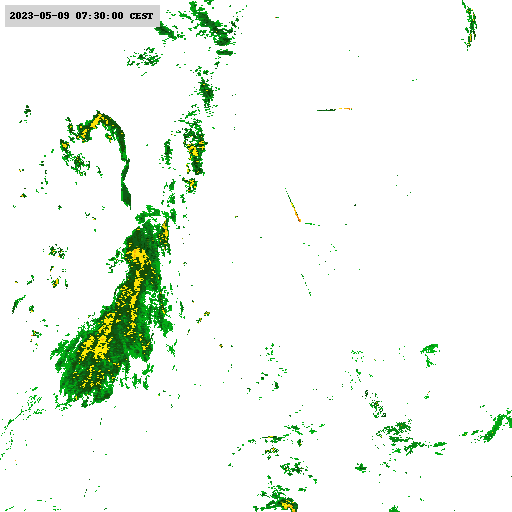

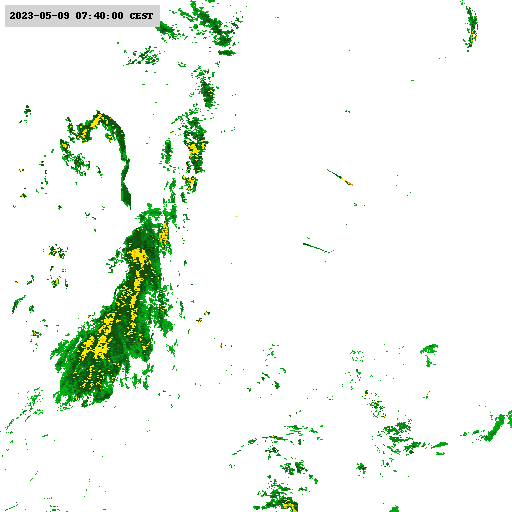

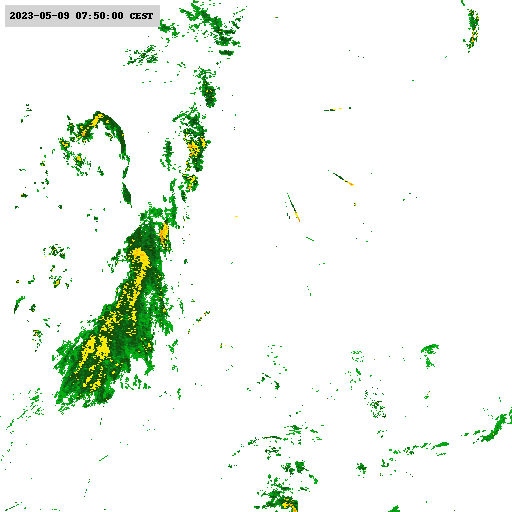

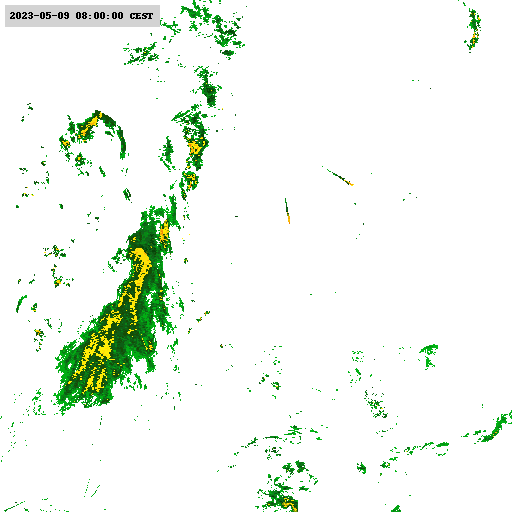

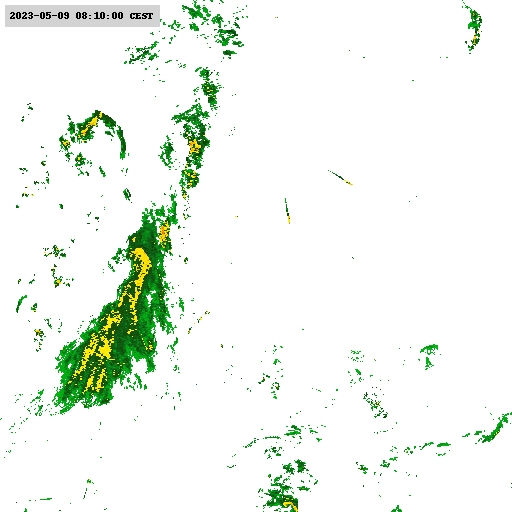

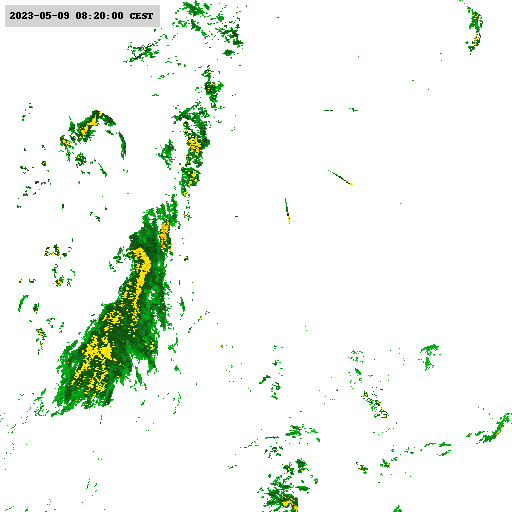

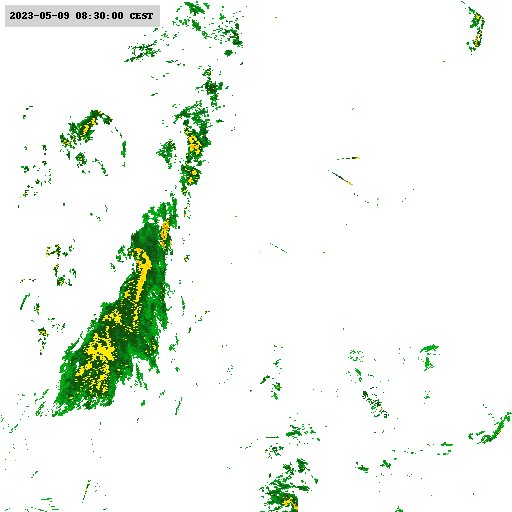

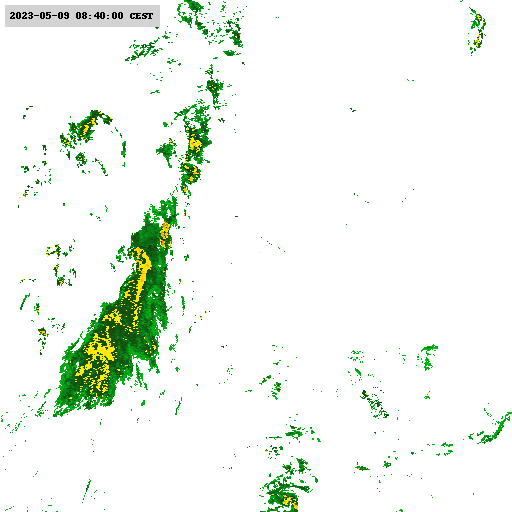

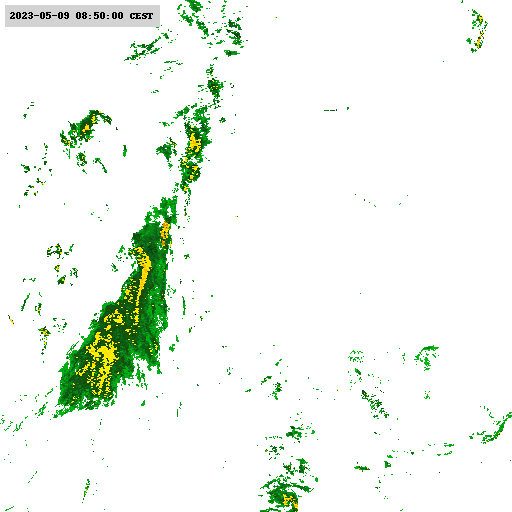

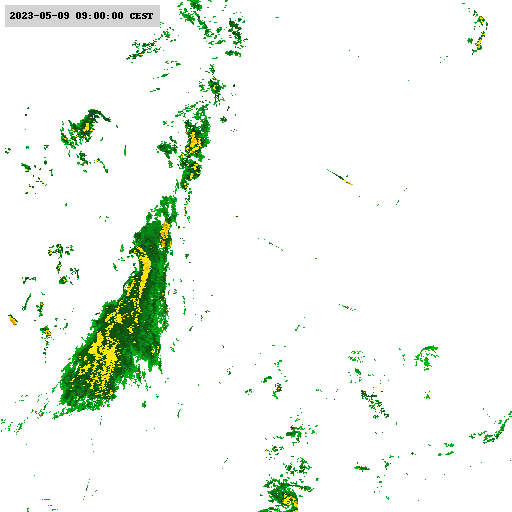

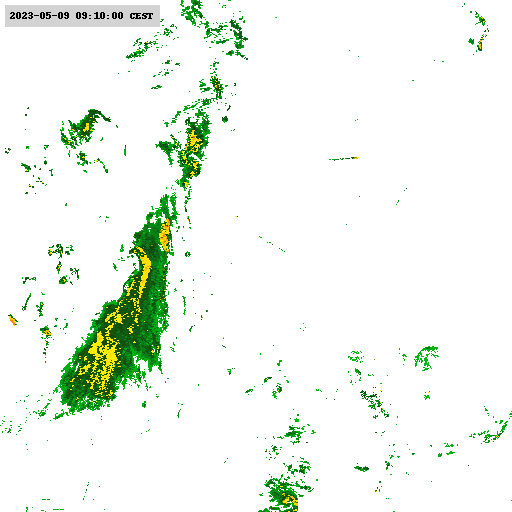

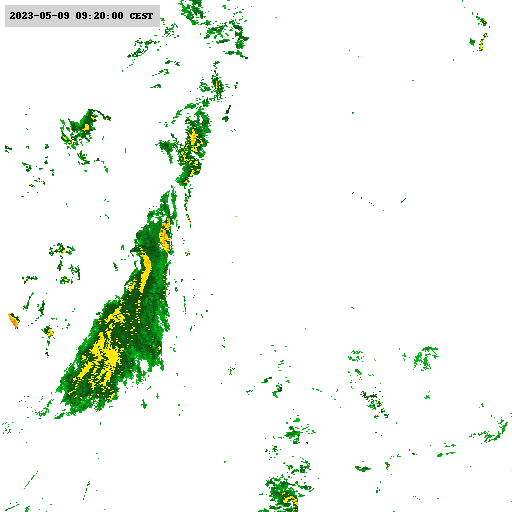

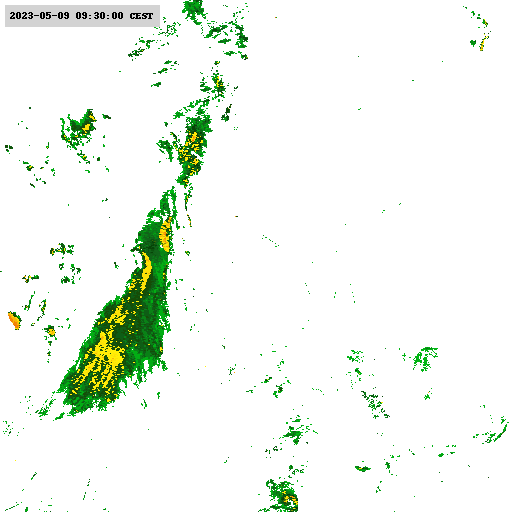

1

In [360]:
display_images(weather_response, my_coordinates, size=512, zoom=3, color=4, smooth=0, snow=0, key='past', save_flg=1)

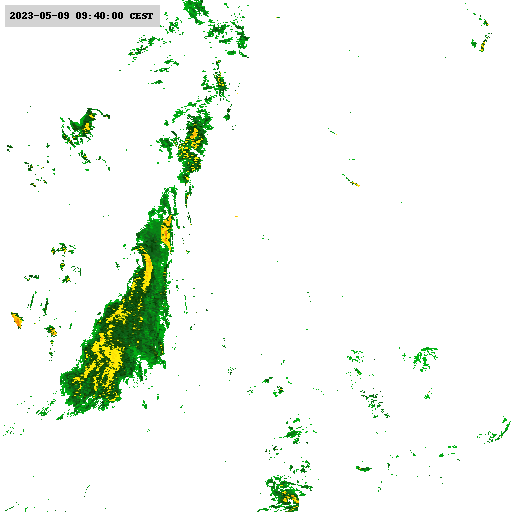

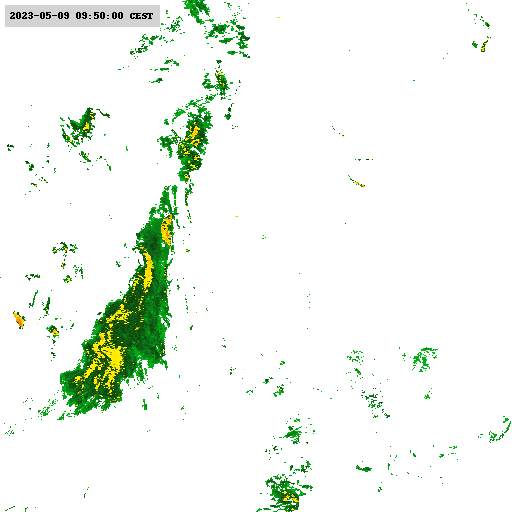

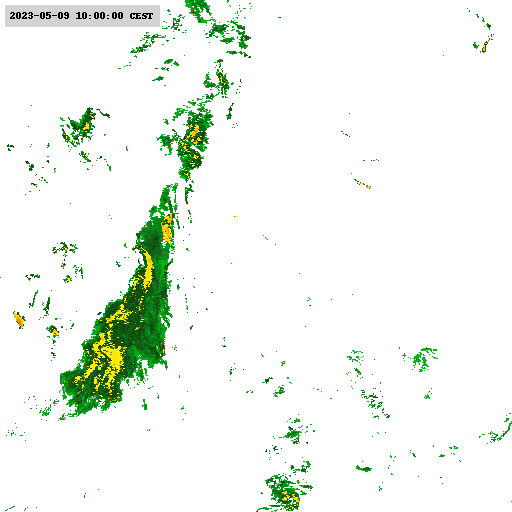

1

In [364]:
# forecast 

display_images(weather_response, my_coordinates, size=512, zoom=3, color=4, smooth=0, snow=0, key='nowcast', save_flg=1)

In [367]:
def filename_key(x):
    return int(x.split()[1].split('.')[0])

def make_gif(source_folder, target_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{source_folder}/*.png"), key=lambda x: filename_key(x))]
    frame_one = frames[0]
    frame_one.save(target_folder + "/" + str.lower(location_name) + f" {request_time: %Y-%m-%d %H:%M:%S}.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0)


In [368]:
# creating a gif file

make_gif(png_past_dir, gif_dir)

In [ ]:
'''
IDEAS: 

- TO COMPARE THE FORECAST AND THE PAST (AFTER SOME TIME)
- TO LAUNCH THE PROJECT EVERY 2 HOURS TO COLLECT INFO FOR ENTIRE DAY AND CREATE GIF

'''

In [ ]:
#     files = glob.glob(frame_folder + '/*')
#     for f in files:
#         os.remove(f)
